In [1]:
from TopML.Manifolds.Hypersphere import HypersphereCanonicalMetric
from TopML.Manifolds.utils import pairwise_distance
from TopML.Manifolds.Steifel import Steifel
import jax.numpy as jnp
import jax
from jax import grad, jacobian, custom_vjp
from TopML.Manifolds.utils import pairwise_distance
import numpy as np

sph = HypersphereCanonicalMetric(3)

In [2]:
import itertools

def generate_sign_combinations(vector):
    """
    Generate all possible sign combinations for a vector of length 3.
    """
    possible_signs = [-1, 1]  # Signs can be -1 (negative) or 1 (positive)

    # Generate all possible sign combinations for each component
    sign_combinations = list(itertools.product(possible_signs, repeat=len(vector)))

    # Multiply each component by the corresponding sign to generate the combinations
    combinations = []
    for signs in sign_combinations:
        combination = [component * sign for component, sign in zip(vector, signs)]
        combinations.append(combination)

    return combinations

# Example usage
vector = [3**(-0.5)]*3  # Example vector of length 3

# Generate all possible sign combinations for the vector
sign_combinations = generate_sign_combinations(vector)

# Print the generated sign combinations
res = []
for combination in sign_combinations:
    res.append(jnp.array(combination)/jnp.linalg.norm(jnp.array(combination)))    
res

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


[Array([-0.5773503, -0.5773503, -0.5773503], dtype=float32),
 Array([-0.5773503, -0.5773503,  0.5773503], dtype=float32),
 Array([-0.5773503,  0.5773503, -0.5773503], dtype=float32),
 Array([-0.5773503,  0.5773503,  0.5773503], dtype=float32),
 Array([ 0.5773503, -0.5773503, -0.5773503], dtype=float32),
 Array([ 0.5773503, -0.5773503,  0.5773503], dtype=float32),
 Array([ 0.5773503,  0.5773503, -0.5773503], dtype=float32),
 Array([0.5773503, 0.5773503, 0.5773503], dtype=float32)]

Generate points along a circle

In [3]:
res = []
rng = jax.random.key(1)

for i in range(30):
    rng,_ = jax.random.split(rng)
    x = jax.random.normal(rng, shape=(sph.m-1,))
    x /= jnp.linalg.norm(x)
    x = (2/3) ** 0.5 * x
    x = jnp.append(x,values=3**(-0.5))
    res.append(x)
res = jnp.stack(res)
ar = jnp.linalg.norm(res,axis=1)
res = res[jnp.where(ar==1)]

In [4]:
xp,yp,zp = res[:,0], res[:,1], res[:,2]

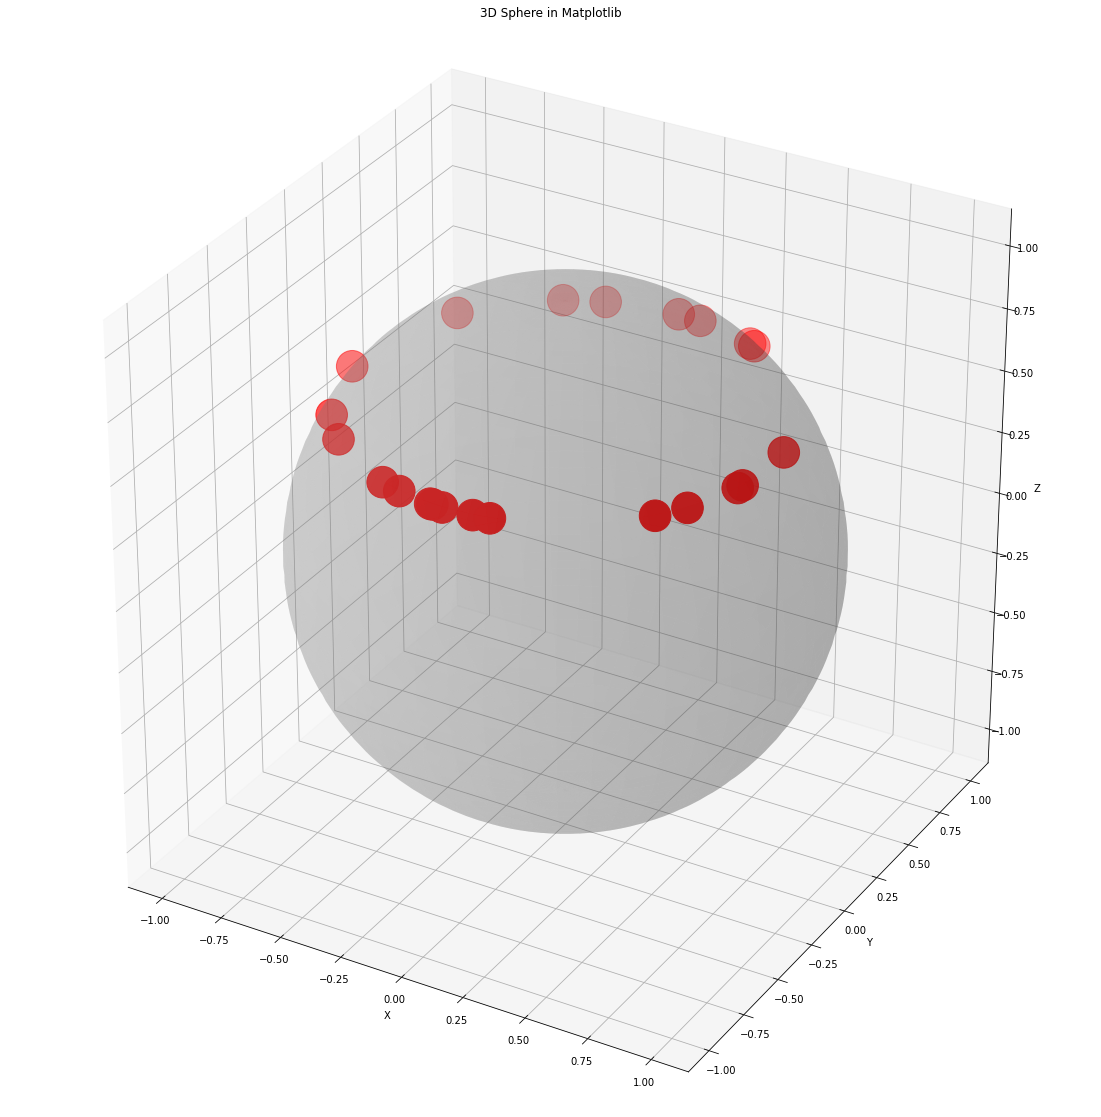

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
radius = 1
theta = np.linspace(0, 2.*np.pi, 100)
phi = np.linspace(0, np.pi, 100)

# Convert to Cartesian coordinates
x = radius * np.outer(np.cos(theta), np.sin(phi))
y = radius * np.outer(np.sin(theta), np.sin(phi))
z = radius * np.outer(np.ones(np.size(theta)), np.cos(phi))
# Create a 3D plot
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

# Plot the sphere
ax.plot_surface(x, y, z, color='gray',alpha=0.2)
ax.scatter(xp, yp, zp, color='r',s=1000)
ax.set_box_aspect([1,1,1])
# Add title and labels
ax.set_title("3D Sphere in Matplotlib")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

plt.show()

In [10]:
sph.dist(res[0],res[1])
pairwise_distance(res[0], res,sph)
dy = grad(pairwise_distance,argnums=0)
dy(sph.random_point(jax.random.key(0)), sph.random_point(jax.random.key(3), 9), sph)

Array([-0.38357744,  0.33944255,  0.23795712], dtype=float32)

In [22]:
p = sph.random_point(jax.random.key(0))
p_set = sph.random_point(jax.random.key(3), 9)

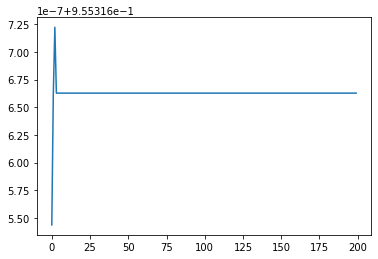

In [184]:
def descent(retraction, p, F, step=1,max_iter=200):
    loss = []
    points = []
    dist_to_true_mean = []
    for _ in range(max_iter):
        dist_to_true_mean.append(sph.dist(true_mean, p))
        points.append(p)
        loss.append(pairwise_distance(p, F, sph))
        a_g = -step*dy(p, F, sph)
        p = retraction(p, a_g)
    return loss, jnp.stack(points), dist_to_true_mean


l,process, dist_to_true_mean = descent(sph.retraction, p, my_set)

plt.plot(l)
plt.show()

In [70]:
one = (1/3)**0.5
two = (2/3)**0.5

my_set = jnp.array(
    [
        [two,0,one],
        [0,two,one],
        [-two,0,one],
        [0,-two,one],
        [one,one,one],
        [-one,one,one],
        [one,-one,one],
        [-one,-one,one]
    ]
)

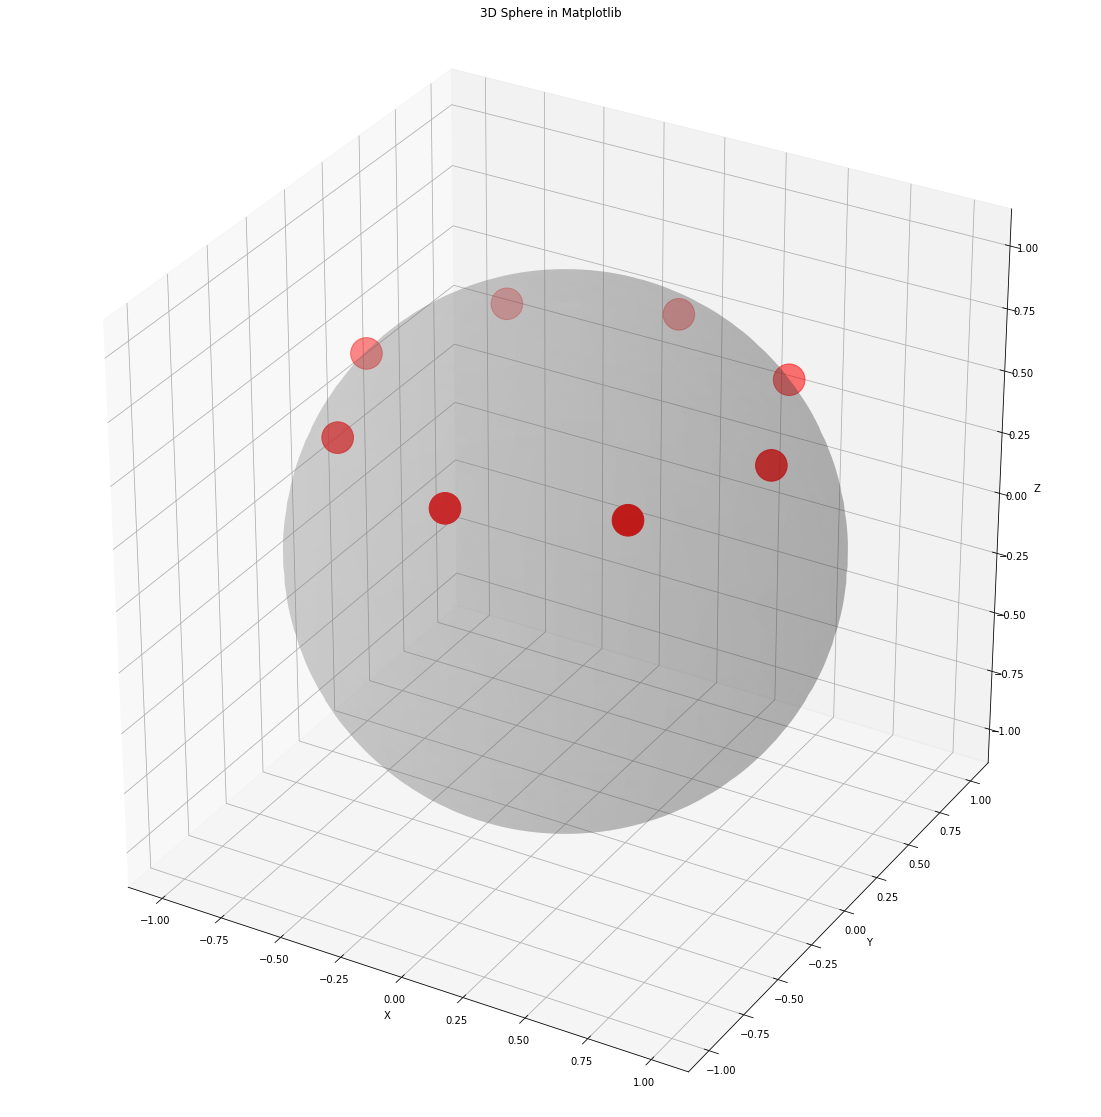

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
radius = 1

theta = np.linspace(0, 2.*np.pi, 100)
phi = np.linspace(0, np.pi, 100)

# Convert to Cartesian coordinates
x = radius * np.outer(np.cos(theta), np.sin(phi))
y = radius * np.outer(np.sin(theta), np.sin(phi))
z = radius * np.outer(np.ones(np.size(theta)), np.cos(phi))
# Create a 3D plot
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

# Plot the sphere
ax.plot_surface(x, y, z, color='gray',alpha=0.2)
#ax.scatter(xp, yp, zp, color='r',s=1000)

xg,yg,zg = my_set[:,0],my_set[:,1],my_set[:,2]

ax.scatter(xg, yg, zg, color='r',s=1000)
ax.set_box_aspect([1,1,1])
# Add title and labels
ax.set_title("3D Sphere in Matplotlib")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

plt.show()

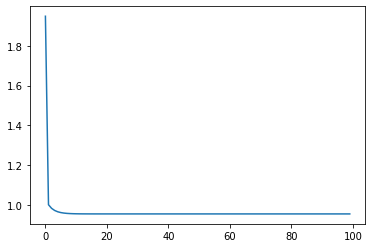

In [198]:
l,process, dist_to_true_mean = descent(sph.retraction, sph.random_point(jax.random.key(45)), my_set, max_iter=100)
plt.plot(l)
plt.show()

0.0011960401


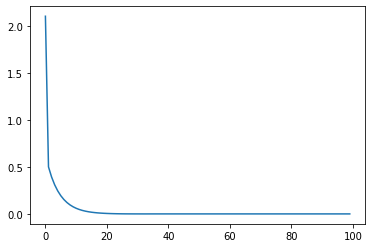

In [199]:
plt.plot(dist_to_true_mean)
print(dist_to_true_mean[-1])
plt.show()

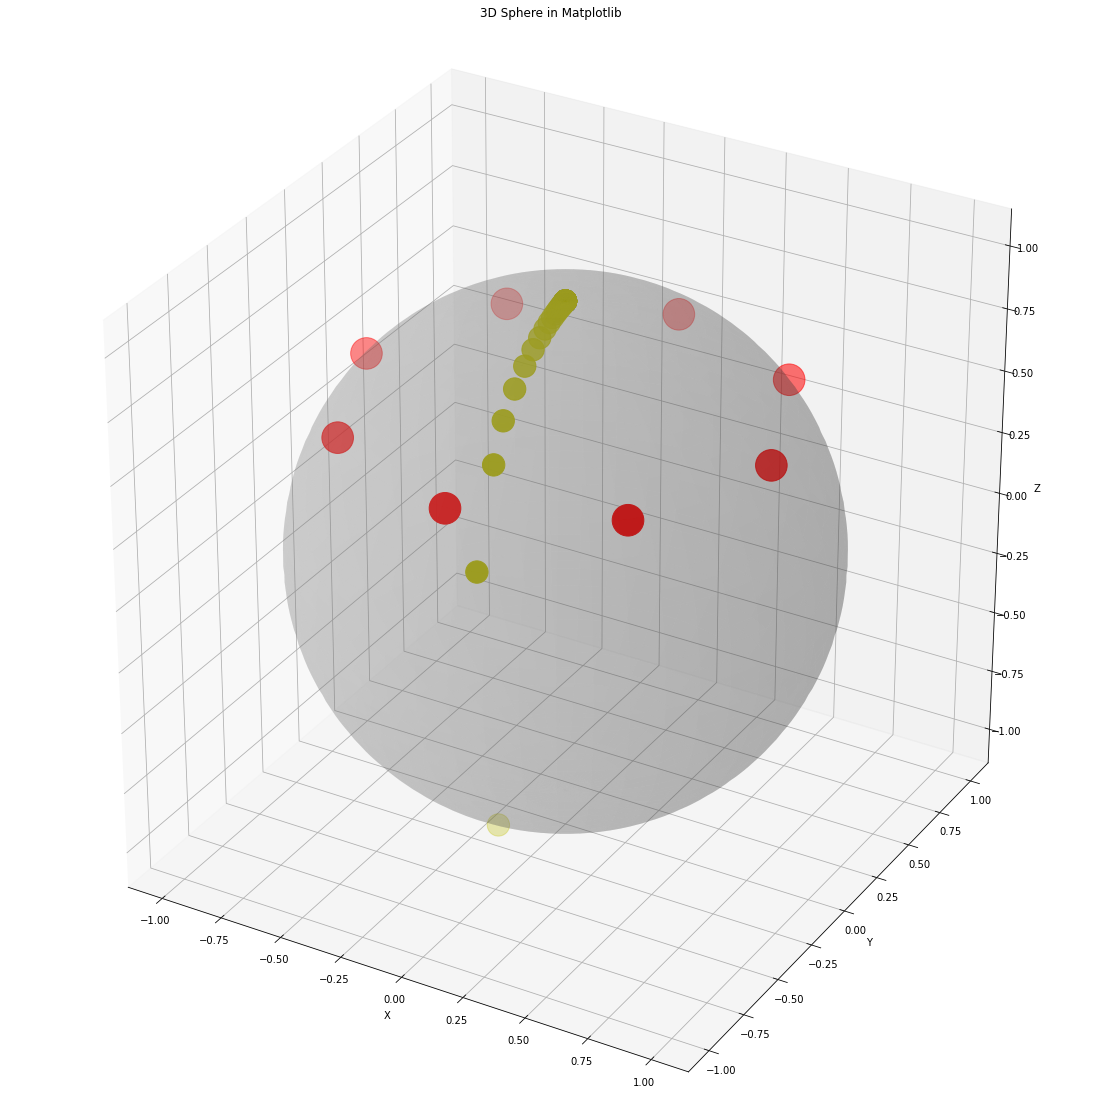

In [193]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
radius = 1

theta = np.linspace(0, 2.*np.pi, 100)
phi = np.linspace(0, np.pi, 100)

# Convert to Cartesian coordinates
x = radius * np.outer(np.cos(theta), np.sin(phi))
y = radius * np.outer(np.sin(theta), np.sin(phi))
z = radius * np.outer(np.ones(np.size(theta)), np.cos(phi))
# Create a 3D plot
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

# Plot the sphere
ax.plot_surface(x, y, z, color='gray',alpha=0.2)
#ax.scatter(xp, yp, zp, color='r',s=1000)

xg,yg,zg = my_set[:,0],my_set[:,1],my_set[:,2]
ax.scatter(xg, yg, zg, color='r',s=1000)


xg,yg,zg = process[:,0],process[:,1],process[:,2]

ax.scatter(xg, yg, zg, color='y',s=500)
ax.set_box_aspect([1,1,1])
# Add title and labels
ax.set_title("3D Sphere in Matplotlib")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

plt.show()

In [167]:
from jax import vmap
def grad_multiply_inverse(d2yy_inv, d2xy):
        return -d2yy_inv @ d2xy


def implicit_df(point, set_points, manifold):   
    dy = grad(pairwise_distance,argnums=0)
    dy_projected = lambda x, X: sph.projection(x, dy(x, X, manifold))
    d2yy = jnp.squeeze(jacobian(dy_projected, argnums=0)(point, set_points))
    d2yy_inv = jnp.linalg.inv(d2yy)
    d2xy = jnp.squeeze(jacobian(dy_projected, argnums=1)(point,set_points)) 
    grad_multiply_inverse_batch = vmap(grad_multiply_inverse, (None, 1), 1)
    dfdx = grad_multiply_inverse_batch(d2yy_inv, d2xy)
    return  jnp.transpose(dfdx, axes=(1,2,0))
    
    
def new_mean(old_mean, set_points, manifold):
    df = implicit_df(old_mean,set_points,manifold)
    new_point = jnp.matmul(df, set_points[:,:,jnp.newaxis]).reshape(len(set_points), -1).sum(axis=0)
    return new_point/jnp.linalg.norm(new_point)



In [174]:
true_mean = jnp.array([0,0,1])

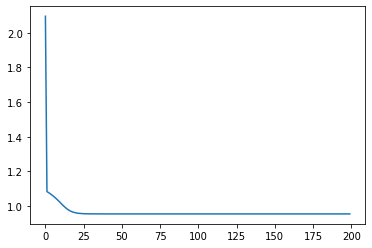

In [178]:
p = sph.random_point(jax.random.key(42))
p_set = my_set
loss = []
process = []
dist_to_true_mean = []
for i in range(200):
    dist_to_true_mean.append(sph.dist(p,true_mean))
    loss.append(pairwise_distance(p,p_set,sph))
    process.append(p)
    p = new_mean(p,p_set,sph)

process = jnp.stack(process)
plt.plot(loss)
plt.show()

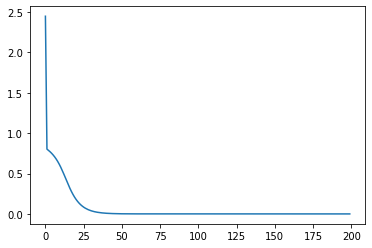

In [179]:
plt.plot(dist_to_true_mean)
plt.show()

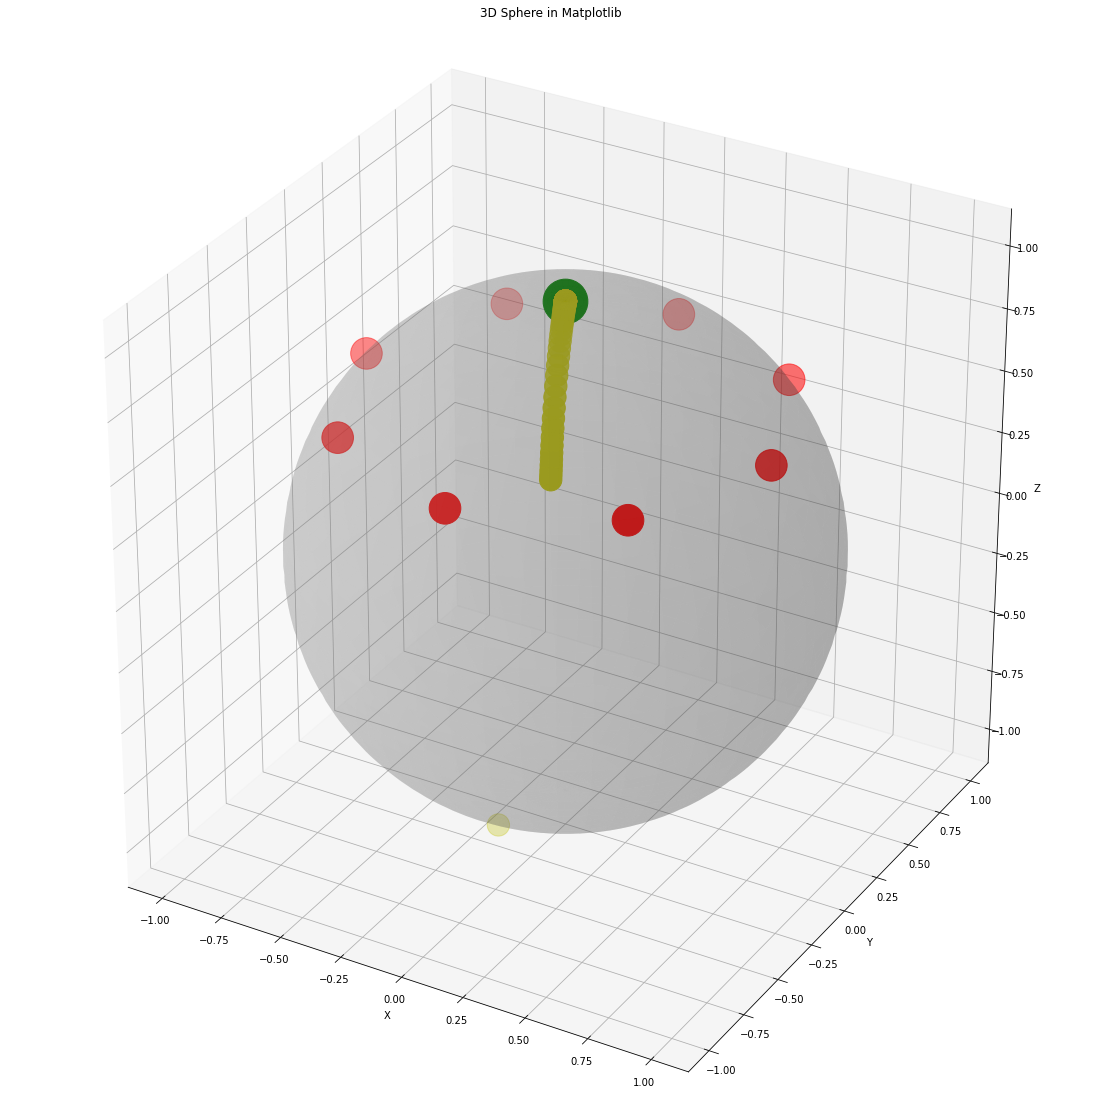

In [181]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
radius = 1

theta = np.linspace(0, 2.*np.pi, 100)
phi = np.linspace(0, np.pi, 100)

# Convert to Cartesian coordinates
x = radius * np.outer(np.cos(theta), np.sin(phi))
y = radius * np.outer(np.sin(theta), np.sin(phi))
z = radius * np.outer(np.ones(np.size(theta)), np.cos(phi))
# Create a 3D plot
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

# Plot the sphere
ax.plot_surface(x, y, z, color='gray',alpha=0.2)
#ax.scatter(xp, yp, zp, color='r',s=1000)

xg,yg,zg = my_set[:,0],my_set[:,1],my_set[:,2]
ax.scatter(xg, yg, zg, color='r',s=1000)


xg,yg,zg = process[:,0],process[:,1],process[:,2]

ax.scatter(xg, yg, zg, color='y',s=500)
ax.scatter(true_mean[0], true_mean[1], true_mean[2], color='g',s=2000)
ax.set_box_aspect([1,1,1])
# Add title and labels
ax.set_title("3D Sphere in Matplotlib")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

plt.show()